<a href="https://colab.research.google.com/github/emreozeren/Uskudar_Unv_YSA/blob/main/Yapay_Sinir_Aglari_234329046_Emre_Ozeren.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 1. Gerekli Kutuphanelerin Yuklenmesi

In [ ]:
import torchvision
import torchvision.transforms as transforms
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from tensorflow.keras.layers import Dense, Layer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix
import random
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

### 2. Veri Seti Yukleme ve On Isleme

#### 2.1. Veri Yukleme

In [ ]:
# Veriyi modele uydurma transformu
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor()
])

# Veri setini indirme
train_dataset = torchvision.datasets.GTSRB(
    root='./data', split='train', download=True, transform=transform)

# Veriyi DataFrame'e dönüştürme
data_list = []

for img, label in train_dataset:
    data_list.append((img.numpy().flatten(), label))

# DataFrame olusturuma
df = pd.DataFrame(data_list, columns=['features', 'label'])

# Cikti olusturma
print(df.head())

100%|██████████| 187M/187M [00:01<00:00, 146MB/s]


Extracting data/gtsrb/GTSRB-Training_fixed.zip to data/gtsrb
                                            features  label
0  [0.29411766, 0.2901961, 0.3254902, 0.39607844,...      0
1  [0.27058825, 0.29411766, 0.29411766, 0.3019608...      0
2  [0.28235295, 0.30588236, 0.30588236, 0.4470588...      0
3  [0.26666668, 0.29803923, 0.34901962, 0.5529412...      0
4  [0.28627452, 0.2901961, 0.29411766, 0.43529412...      0


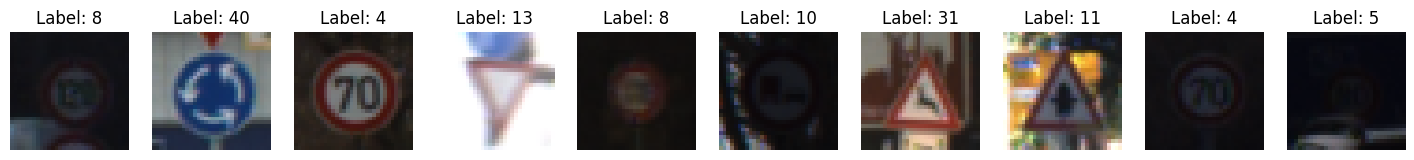

In [ ]:
# 10 random goruntu gosterme
num_images_to_show = 10
random_indices = random.sample(range(len(train_dataset)), num_images_to_show)

fig, axes = plt.subplots(1, num_images_to_show, figsize=(18, 5))

for i, index in enumerate(random_indices):
  image, label = train_dataset[index]
  axes[i].imshow(np.transpose(image.numpy(), (1, 2, 0)))
  axes[i].set_title(f"Label: {label}")
  axes[i].axis('off')

plt.show()

In [ ]:
print(train_dataset)

Dataset GTSRB
    Number of datapoints: 26640
    Root location: ./data
    StandardTransform
Transform: Compose(
               Resize(size=(32, 32), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )


#### 2.2. Eksik Degerlerin Islenmesi

In [ ]:
print(df.isnull().sum())

# Eksik degerleri mode ile doldurma

for index, row in df.iterrows():
    if pd.isnull(row['features']).any():  # Dizide herhangi bir eksik değer var mı?
        # df.loc[index, 'features'] = np.nan_to_num(row['features'],
        # fill_value=0)
        df['label'] = df['label'].fillna(df['label'].mode()[0])

# Eksik degerleri kontrol etme
print('Mode ile doldurma sonrası')
print(df.isnull().sum())

features    0
label       0
dtype: int64
Mode ile doldurma sonrası
features    0
label       0
dtype: int64


#### 2.3. Veri Setini Eğitim ve Test Olarak Ayrıma

In [ ]:
# Ozellik matrisi (X) ve hedef degisken (y) olusturma
X = np.stack(df['features'].values)
y = df['label'].values

# Veriyi egitim ve test kumelerine ayirma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Sonuclari gosterme
print("Eğitim kümesi boyutu:", X_train.shape)
print("Test kümesi boyutu:", X_test.shape)

Eğitim kümesi boyutu: (21312, 3072)
Test kümesi boyutu: (5328, 3072)


#### 2.4. Ozellik Olcekleme (Feature Scaling)

In [ ]:
# Standartlastirma icin StandardScaler kullanma
scaler = StandardScaler()
X_train_StandartScaler = scaler.fit_transform(X_train)
X_test_StandartScaler = scaler.transform(X_test)

np.set_printoptions(linewidth=200)
# Standartlastirilmis verileri gosterme
print("Standartlaştırılmış eğitim verileri:\n", X_train_StandartScaler[:5])
print("Standartlaştırılmış test verileri:\n", X_test_StandartScaler[:5])

Standartlaştırılmış eğitim verileri:
 [[ 0.75200784  0.72539014  0.71891266 ...  1.5014181   1.5020005   1.4908231 ]
 [-0.76304746 -0.780099   -0.7829499  ... -0.10837136 -0.02125802  0.04274715]
 [ 0.12508838  0.26719776  0.48383856 ...  2.923659    2.9467404   2.9233284 ]
 [-0.78916913 -0.8586462  -0.86130786 ... -0.6241292  -0.6179985  -0.6112226 ]
 [-0.67162174 -0.5968221  -0.62623376 ... -0.54598397 -0.53948003 -0.5956519 ]]
Standartlaştırılmış test verileri:
 [[-0.37122285 -0.780099   -0.87436754 ... -0.530355   -0.2411098   0.94584835]
 [-0.9850814  -0.97646713 -0.9919046  ... -0.10837136 -0.13118394 -0.15967211]
 [-0.14918885 -0.11244728 -0.14302585 ... -0.5147259  -0.5080726  -0.47108626]
 [ 1.979725    1.9559639   1.8159251  ...  0.5167896   0.49696392  0.47872698]
 [-0.86753404 -0.8324638  -0.8221289  ... -0.6553872  -0.68081325 -0.6579348 ]]


In [ ]:
# Standartlastirma icin MinMaxScaler kullanma
scaler = MinMaxScaler()
X_train_MinMaxScaler = scaler.fit_transform(X_train)
X_test_MinMaxScaler = scaler.transform(X_test)

# Olceklendirilmis verileri gosterme
print("MinMaxScaler ile ölçeklendirilmiş eğitim verileri:\n", X_train_MinMaxScaler[:5])
print("MinMaxScaler ile ölçeklendirilmiş test verileri:\n", X_test_MinMaxScaler[:5])

MinMaxScaler ile ölçeklendirilmiş eğitim verileri:
 [[0.572      0.564      0.564      ... 0.6345382  0.63052213 0.6392157 ]
 [0.10800001 0.104      0.104      ... 0.22088353 0.24096386 0.27450982]
 [0.38       0.424      0.492      ... 1.         1.         1.        ]
 [0.09999999 0.08       0.08       ... 0.08835341 0.08835341 0.10980392]
 [0.136      0.16000001 0.15200001 ... 0.10843374 0.10843374 0.11372549]]
MinMaxScaler ile ölçeklendirilmiş test verileri:
 [[0.228      0.104      0.07600001 ... 0.11244981 0.18473895 0.5019608 ]
 [0.04       0.044      0.04       ... 0.22088353 0.2128514  0.22352941]
 [0.296      0.308      0.29999998 ... 0.11646587 0.11646587 0.14509805]
 [0.948      0.94       0.90000004 ... 0.38152608 0.37349397 0.38431373]
 [0.07600001 0.088      0.09199999 ... 0.08032128 0.07228916 0.09803922]]


### 3.Model Egitimi ve Hiperparametre Denemeleri

#### 3.1. MLP (Multi Layer Perceptron) Modeli

**https://scikit-learn.org/stable/modules/decomposition.html**

sayfasından derlediğim bilgiler ışığında **"Principal Compoenent Analysis (PCA)"** modeli; çok değişkenli bir veri kümesini, varyansın maksimum miktarını açıklayan bir dizi ardışık ortogonal (*tüm çiftlerinin birbirine dik olduğu ve skaler çarpımlarının sonucu 0 olan vektör kümesi*) bileşende ayrıştırmak için kullanılır. Scikit-learn'de PCA, uyum yönteminde n bileşeni öğrenen ve bu bileşenlere yansıtmak için yeni veriler üzerinde kullanılabilen bir dönüştürücü nesne olarak uygulanır.

PCA, "Singular Value Decomposition (SVD)" yi uygulamadan önce her özellik için girdi verilerini merkezler ancak ölçeklendirmez. İsteğe bağlı ***whiten=True*** parametresi, her bir bileşeni birim varyansa ölçeklendirirken verilerin tekil uzaya yansıtılmasını mümkün kılar. Bu, genellikle aşağı akış modelleri sinyalin izotropisi hakkında güçlü varsayımlarda bulunuyorsa kullanışlıdır: örneğin RBF çekirdekli Destek Vektör Makineleri ve K-Means kümeleme algoritması için durum böyledir.

**Yine scikitlearn web sayfası API başlığı altında yer alan dokümantasyona göre parametreler aşağıdaki şekilde tanımlanabilmektedir.**
.

##### **hidden_layer_sizes :**
array-like of shape(n_layers - 2,), default=(100,)
Birinci eleman, birinci gizli katmandaki nöron sayısını temsil eder.

##### **activation :**
{'identity', 'logistic', 'tanh', 'relu'}, default='relu'
Gizli katman için aktivasyon fonksiyonu.

'identity', no-op aktivasyon, doğrusal darboğaz uygulamak için kullanışlıdır, f(x) = x döndürür

'logistic', lojistik sigmoid fonksiyonu, f(x) = 1 / (1 + exp(-x)) döndürür.

Hiperbolik tan fonksiyonu olan 'tanh', f(x) = tanh(x) döndürür.

'relu', düzeltilmiş doğrusal birim fonksiyonu, f(x) = max(0, x) döndürür.

##### **solver :**
{'lbfgs', 'sgd', 'adam'}, varsayılan='adam'
Ağırlık optimizasyonu için çözücü.

'lbfgs' quasi-Newton yöntemleri ailesinden bir optimize edicidir.

'sgd' stokastik gradyan inişini ifade eder.

'adam' Kingma, Diederik ve Jimmy Ba tarafından önerilen stokastik gradyan tabanlı bir optimize ediciyi ifade eder.

Adam optimizer ve SGD arasında bir karşılaştırma için MLPClassifier için Stokastik öğrenme stratejilerini karşılaştırın bölümüne bakın.

Not: Varsayılan çözücü 'adam', hem eğitim süresi hem de doğrulama puanı açısından nispeten büyük veri kümelerinde (binlerce eğitim örneği veya daha fazlasıyla) oldukça iyi çalışır. Ancak küçük veri kümeleri için 'lbfgs' daha hızlı yakınsayabilir ve daha iyi performans gösterebilir.

##### **alfa :**
float, varsayılan=0.0001
L2 düzenlileştirme teriminin gücü. L2 düzenlileştirme terimi, kayba eklendiğinde örnek boyutuna bölünür.

Değişken düzenlileştirmenin örnek kullanımı ve görselleştirmesi için bkz.

##### **batch_size :**
int, default='auto'
Stokastik optimize ediciler için mini partilerin boyutu. Çözücü 'lbfgs' ise sınıflandırıcı minibatch kullanmayacaktır. “auto” olarak ayarlandığında, batch_size=min(200, n_samples).

##### **learning_rate :**
{'constant', 'invscaling', 'adaptive'}, default='constant'
Ağırlık güncellemeleri için öğrenme oranı çizelgesi.

'constant', 'learning_rate_init' tarafından verilen sabit bir öğrenme oranıdır.

'invscaling', 'power_t' ters ölçekleme üssünü kullanarak her 't' zaman adımında öğrenme oranını kademeli olarak azaltır. effective_learning_rate = learning_rate_init / pow(t, power_t)

'adaptive' eğitim kaybı azalmaya devam ettiği sürece öğrenme oranını 'learning_rate_init' olarak sabit tutar. Her iki ardışık epok eğitim kaybını en az tol kadar azaltamadığında veya 'early_stopping' açıksa doğrulama puanını en az tol kadar artıramadığında, mevcut öğrenme oranı 5'e bölünür.

Yalnızca çözücü='sgd' olduğunda kullanılır.

##### **learning_rate_init :**
float, varsayılan=0.001
Kullanılan ilk öğrenme oranı. Ağırlıkların güncellenmesindeki adım boyutunu kontrol eder. Yalnızca çözücü='sgd' veya 'adam' olduğunda kullanılır.

##### **power_t :**
float, varsayılan=0.5
Ters ölçekleme öğrenme oranı için üs. Learning_rate 'invscaling' olarak ayarlandığında etkin öğrenme oranının güncellenmesinde kullanılır. Sadece solver='sgd' olduğunda kullanılır.

##### **max_iter :**
int, default=200
Maksimum iterasyon sayısı. Çözücü yakınsama ('tol' ile belirlenir) veya bu yineleme sayısına kadar yineleme yapar. Stokastik çözücüler ('sgd', 'adam') için, bunun gradyan adımlarının sayısını değil, epok sayısını (her veri noktasının kaç kez kullanılacağını) belirlediğini unutmayın.

##### **shuffle :**
bool, default=True
Her iterasyonda örneklerin karıştırılıp karıştırılmayacağı. Yalnızca çözücü='sgd' veya 'adam' olduğunda kullanılır.

##### **random_state :**
int, RandomState örneği, default=None
Ağırlıklar ve önyargı başlatma için rastgele sayı üretimini, erken durdurma kullanılıyorsa eğitim-test ayrımını ve çözücü='sgd' veya 'adam' olduğunda toplu örneklemeyi belirler. Birden fazla fonksiyon çağrısında tekrarlanabilir sonuçlar için bir int değeri geçirin.

##### 3.1. MLP Modeli Min-Max Scaler

In [ ]:
# MinMaxScaler ile olceklendirilmis verileri kullanarak MLP modelini olusturma
mlp_model1 = MLPClassifier(hidden_layer_sizes=(100, 50),
                          max_iter=100,
                          alpha=0.0001,
                          solver='adam',
                          verbose=10,
                          random_state=21,
                          tol=0.000000001)

# Modeli egitme
mlp_model1.fit(X_train_MinMaxScaler, y_train)

# Test verileri uzerinde tahmin yapma
y_pred_minmax = mlp_model1.predict(X_test_MinMaxScaler)

# Sonuclari degerlendirme
print(classification_report(y_test, y_pred_minmax))
print(confusion_matrix(y_test, y_pred_minmax))

Iteration 1, loss = 2.97457005
Iteration 2, loss = 1.93589746
Iteration 3, loss = 1.42608883
Iteration 4, loss = 1.12311248
Iteration 5, loss = 0.93510876
Iteration 6, loss = 0.78481542
Iteration 7, loss = 0.69032608
Iteration 8, loss = 0.59905744
Iteration 9, loss = 0.55262710
Iteration 10, loss = 0.49353824
Iteration 11, loss = 0.45228538
Iteration 12, loss = 0.41669932
Iteration 13, loss = 0.38893821
Iteration 14, loss = 0.38206770
Iteration 15, loss = 0.35015193
Iteration 16, loss = 0.32645620
Iteration 17, loss = 0.29847746
Iteration 18, loss = 0.29119711
Iteration 19, loss = 0.27655832
Iteration 20, loss = 0.27493665
Iteration 21, loss = 0.26355867
Iteration 22, loss = 0.24912377
Iteration 23, loss = 0.24941941
Iteration 24, loss = 0.23594669
Iteration 25, loss = 0.21337272
Iteration 26, loss = 0.21212670
Iteration 27, loss = 0.21705919
Iteration 28, loss = 0.20902709
Iteration 29, loss = 0.20450166
Iteration 30, loss = 0.18750300
Iteration 31, loss = 0.17723617
Iteration 32, los

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
# MinMaxScaler ile olceklendirilmis verileri kullanarak MLP modelini olusturma
mlp_model2 = MLPClassifier(hidden_layer_sizes=(175, 75),
                          max_iter=150,
                          alpha=0.0001,
                          solver='adam',
                          verbose=10,
                          random_state=21,
                          tol=0.000000001)

# Modeli egitme
mlp_model2.fit(X_train_MinMaxScaler, y_train)

# Test verileri uzerinde tahmin yapma
y_pred_minmax = mlp_model2.predict(X_test_MinMaxScaler)

# Sonuclari degerlendirme
print(classification_report(y_test, y_pred_minmax))
print(confusion_matrix(y_test, y_pred_minmax))

Iteration 1, loss = 2.85059223
Iteration 2, loss = 1.64038557
Iteration 3, loss = 1.13528969
Iteration 4, loss = 0.85658617
Iteration 5, loss = 0.70097556
Iteration 6, loss = 0.58365524
Iteration 7, loss = 0.49158589
Iteration 8, loss = 0.44251847
Iteration 9, loss = 0.39109593
Iteration 10, loss = 0.37726087
Iteration 11, loss = 0.32561005
Iteration 12, loss = 0.31099009
Iteration 13, loss = 0.29170938
Iteration 14, loss = 0.26899781
Iteration 15, loss = 0.23728256
Iteration 16, loss = 0.24350326
Iteration 17, loss = 0.22151908
Iteration 18, loss = 0.24662931
Iteration 19, loss = 0.20089546
Iteration 20, loss = 0.19253102
Iteration 21, loss = 0.18861501
Iteration 22, loss = 0.18261646
Iteration 23, loss = 0.17230739
Iteration 24, loss = 0.15619596
Iteration 25, loss = 0.14625733
Iteration 26, loss = 0.14082864
Iteration 27, loss = 0.14901191
Iteration 28, loss = 0.13005415
Iteration 29, loss = 0.17312551
Iteration 30, loss = 0.12512680
Iteration 31, loss = 0.12488153
Iteration 32, los

##### 3.1. MLP Modeli Min-Max Scaler Farklı Hiperparametreler

In [ ]:
# MLP modelini farkli parametrelerle olusturma
mlp_model3 = MLPClassifier(hidden_layer_sizes=(50, 25),  # Gizli katman boyutlari degistirme
                          activation='relu',  # Aktivasyon fonksiyonu degistirme (relu, tanh, logistic)
                          solver='sgd',  # Optimizasyon algoritmasi degistirme (adam, lbfgs, sgd)
                          learning_rate='adaptive',  # Ogrenme orani stratejisi degistirme (constant, invscaling, adaptive)
                          learning_rate_init=0.01,  # Baslangic ogrenme orani degistirme
                          max_iter=100,  # Maksimum yineleme sayisi arttirildi
                          alpha=0.001,  # Duzenleme parametresi degistirme
                          random_state=21,
                          verbose=10,
                          tol=0.000000001)

# Modeli egitme
mlp_model3.fit(X_train_MinMaxScaler, y_train)

# Test verileri uzerinde tahmin yapma
y_pred_minmax = mlp_model3.predict(X_test_MinMaxScaler)

# Sonuclari degerlendirme
print(classification_report(y_test, y_pred_minmax))
print(confusion_matrix(y_test, y_pred_minmax))

Iteration 1, loss = 3.37001323
Iteration 2, loss = 2.49865966
Iteration 3, loss = 1.84390311
Iteration 4, loss = 1.42495466
Iteration 5, loss = 1.13413659
Iteration 6, loss = 0.98673014
Iteration 7, loss = 0.79423498
Iteration 8, loss = 0.73992359
Iteration 9, loss = 0.63933366
Iteration 10, loss = 0.59023726
Iteration 11, loss = 0.53010918
Iteration 12, loss = 0.50593533
Iteration 13, loss = 0.45159198
Iteration 14, loss = 0.43934765
Iteration 15, loss = 0.40451949
Iteration 16, loss = 0.38500899
Iteration 17, loss = 0.35745490
Iteration 18, loss = 0.34208047
Iteration 19, loss = 0.34656800
Iteration 20, loss = 0.34701405
Iteration 21, loss = 0.30332846
Iteration 22, loss = 0.30275000
Iteration 23, loss = 0.29357627
Iteration 24, loss = 0.27246953
Iteration 25, loss = 0.27103012
Iteration 26, loss = 0.25615773
Iteration 27, loss = 0.26015021
Iteration 28, loss = 0.24634112
Iteration 29, loss = 0.24552367
Iteration 30, loss = 0.24187731
Iteration 31, loss = 0.21472194
Iteration 32, los

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
# MLP modelini farkli parametrelerle olusturma
mlp_model = MLPClassifier(hidden_layer_sizes=(200, 100),  # Gizli katman boyutlari degistirme
                          activation='relu',  # Aktivasyon fonksiyonu degistirme (relu, tanh, logistic)
                          solver='sgd',  # Optimizasyon algoritmasi degistirme (adam, lbfgs, sgd)
                          learning_rate='adaptive',  # Ogrenme orani stratejisi degistirme (constant, invscaling, adaptive)
                          learning_rate_init=0.01,  # Baslangic ogrenme orani degistirme
                          max_iter=200,  # Maksimum yineleme sayisi arttirildi
                          alpha=0.001,  # Duzenleme parametresi degistirme
                          random_state=21,
                          verbose=10,
                          tol=0.000000001
)

# Modeli egitme
mlp_model.fit(X_train_MinMaxScaler, y_train)

# Test verileri uzerinde tahmin yapma
y_pred_minmax = mlp_model.predict(X_test_MinMaxScaler)

# Sonuclari degerlendirme
print(classification_report(y_test, y_pred_minmax))
print(confusion_matrix(y_test, y_pred_minmax))

Iteration 1, loss = 2.96390345
Iteration 2, loss = 1.72337743
Iteration 3, loss = 1.13141323
Iteration 4, loss = 0.83652501
Iteration 5, loss = 0.63480985
Iteration 6, loss = 0.51903732
Iteration 7, loss = 0.49225279
Iteration 8, loss = 0.38674320
Iteration 9, loss = 0.34507306
Iteration 10, loss = 0.31977810
Iteration 11, loss = 0.28483253
Iteration 12, loss = 0.26009143
Iteration 13, loss = 0.24977019
Iteration 14, loss = 0.23112628
Iteration 15, loss = 0.21551438
Iteration 16, loss = 0.20110129
Iteration 17, loss = 0.18745324
Iteration 18, loss = 0.17767592
Iteration 19, loss = 0.16876631
Iteration 20, loss = 0.16522067
Iteration 21, loss = 0.15033351
Iteration 22, loss = 0.14492300
Iteration 23, loss = 0.13539353
Iteration 24, loss = 0.13190516
Iteration 25, loss = 0.12958003
Iteration 26, loss = 0.11774089
Iteration 27, loss = 0.11275162
Iteration 28, loss = 0.11583095
Iteration 29, loss = 0.10669559
Iteration 30, loss = 0.10473734
Iteration 31, loss = 0.10434853
Iteration 32, los

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Gizli katman boyutları değiştirildiğinde sonuçlardaki değişim (iyileşme) gözlenebildi.

##### 3.1. MLP Modeli Standart Scaler

In [ ]:
# StandartScaler ile olceklendirilmis verileri kullanarak MLP modelini olusturma
mlp_model_standart1 = MLPClassifier(hidden_layer_sizes=(100, 50),
                                   max_iter=100,
                                   alpha=0.0001,
                                   solver='adam',
                                   verbose=10,
                                   random_state=21,
                                   tol=0.000000001)

# Modeli egitme
mlp_model_standart1.fit(X_train_StandartScaler, y_train)

# Test verileri uzerinde tahmin yapma
y_pred_standart = mlp_model_standart1.predict(X_test_StandartScaler)

# Sonuclari degerlendirme
print("StandartScaler ile MLP Model Sonuçları:")
print(classification_report(y_test, y_pred_standart))
print(confusion_matrix(y_test, y_pred_standart))

Iteration 1, loss = 2.27432229
Iteration 2, loss = 0.99869303
Iteration 3, loss = 0.59792634
Iteration 4, loss = 0.45346537
Iteration 5, loss = 0.35498968
Iteration 6, loss = 0.28880301
Iteration 7, loss = 0.26412330
Iteration 8, loss = 0.21091193
Iteration 9, loss = 0.21752964
Iteration 10, loss = 0.16704621
Iteration 11, loss = 0.18737964
Iteration 12, loss = 0.15865429
Iteration 13, loss = 0.15635798
Iteration 14, loss = 0.12344757
Iteration 15, loss = 0.11736772
Iteration 16, loss = 0.11798298
Iteration 17, loss = 0.09739880
Iteration 18, loss = 0.12122257
Iteration 19, loss = 0.08886870
Iteration 20, loss = 0.10068733
Iteration 21, loss = 0.09221471
Iteration 22, loss = 0.12947126
Iteration 23, loss = 0.09359132
Iteration 24, loss = 0.07178389
Iteration 25, loss = 0.07598876
Iteration 26, loss = 0.06895326
Iteration 27, loss = 0.13354061
Iteration 28, loss = 0.17552332
Iteration 29, loss = 0.08704802
Iteration 30, loss = 0.06123741
Iteration 31, loss = 0.07185019
Iteration 32, los

In [ ]:
# StandartScaler ile olceklendirilmis verileri kullanarak MLP modelini olusturma
mlp_model_standart2 = MLPClassifier(hidden_layer_sizes=(175, 75),
                                   max_iter=150,
                                   alpha=0.0001,
                                   solver='adam',
                                   verbose=10,
                                   random_state=21,
                                   tol=0.000000001)

# Modeli egitme
mlp_model_standart2.fit(X_train_StandartScaler, y_train)

# Test verileri uzerinde tahmin yapma
y_pred_standart = mlp_model_standart2.predict(X_test_StandartScaler)

# Sonuclari degerlendirme
print("StandartScaler ile MLP Model Sonuçları:")
print(classification_report(y_test, y_pred_standart))
print(confusion_matrix(y_test, y_pred_standart))

Iteration 1, loss = 2.05428219
Iteration 2, loss = 0.86673968
Iteration 3, loss = 0.52808390
Iteration 4, loss = 0.37441513
Iteration 5, loss = 0.32849862
Iteration 6, loss = 0.26342070
Iteration 7, loss = 0.26289027
Iteration 8, loss = 0.17638450
Iteration 9, loss = 0.20479830
Iteration 10, loss = 0.17220955
Iteration 11, loss = 0.15244569
Iteration 12, loss = 0.16135824
Iteration 13, loss = 0.18953425
Iteration 14, loss = 0.15083244
Iteration 15, loss = 0.16278966
Iteration 16, loss = 0.14735532
Iteration 17, loss = 0.12660013
Iteration 18, loss = 0.08691848
Iteration 19, loss = 0.12324859
Iteration 20, loss = 0.08818346
Iteration 21, loss = 0.07701536
Iteration 22, loss = 0.07514095
Iteration 23, loss = 0.11530074
Iteration 24, loss = 0.11256414
Iteration 25, loss = 0.11135739
Iteration 26, loss = 0.11877344
Iteration 27, loss = 0.08670388
Iteration 28, loss = 0.07956395
Iteration 29, loss = 0.07071853
Iteration 30, loss = 0.08103573
Iteration 31, loss = 0.13767336
Iteration 32, los

##### 3.1. MLP Modeli Standart Scaler Farklı Hiperparametreler

In [ ]:
# MLP modelini farkli parametrelerle olusturma
mlp_model_standart3 = MLPClassifier(hidden_layer_sizes=(50, 25),  # Gizli katman boyutlari degistirme
                          activation='relu',  # Aktivasyon fonksiyonu degistirme (relu, tanh, logistic)
                          solver='sgd',  # Optimizasyon algoritmasi degistirme (adam, lbfgs, sgd)
                          learning_rate='adaptive',  # Ogrenme orani stratejisi degistirme (constant, invscaling, adaptive)
                          learning_rate_init=0.01,  # Baslangic ogrenme orani degistirme
                          max_iter=100,  # Maksimum yineleme sayisi arttirildi
                          alpha=0.001,  # Duzenleme parametresi degistirme
                          random_state=21,
                          verbose=10,
                          tol=0.000000001)

# Modeli egitme
mlp_model_standart3.fit(X_train_StandartScaler, y_train)

# Test verileri uzerinde tahmin yapma
y_pred_standart = mlp_model_standart3.predict(X_test_StandartScaler)

# Sonuclari degerlendirme
print("StandartScaler ile MLP Model Sonuçları:")
print(classification_report(y_test, y_pred_standart))
print(confusion_matrix(y_test, y_pred_standart))

Iteration 1, loss = 2.69432365
Iteration 2, loss = 1.32602665
Iteration 3, loss = 0.79802809
Iteration 4, loss = 0.55884375
Iteration 5, loss = 0.43285581
Iteration 6, loss = 0.36242628
Iteration 7, loss = 0.30156086
Iteration 8, loss = 0.25407161
Iteration 9, loss = 0.21241459
Iteration 10, loss = 0.18677230
Iteration 11, loss = 0.17116014
Iteration 12, loss = 0.15465786
Iteration 13, loss = 0.14506754
Iteration 14, loss = 0.15007608
Iteration 15, loss = 0.12515822
Iteration 16, loss = 0.10566259
Iteration 17, loss = 0.09750775
Iteration 18, loss = 0.09267001
Iteration 19, loss = 0.09335845
Iteration 20, loss = 0.08991092
Iteration 21, loss = 0.07964100
Iteration 22, loss = 0.06887387
Iteration 23, loss = 0.06810145
Iteration 24, loss = 0.06917514
Iteration 25, loss = 0.06306404
Iteration 26, loss = 0.05593031
Iteration 27, loss = 0.05504597
Iteration 28, loss = 0.05657716
Iteration 29, loss = 0.06372844
Iteration 30, loss = 0.04743782
Iteration 31, loss = 0.04806759
Iteration 32, los

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
# MLP modelini farkli parametrelerle olusturma
mlp_model_standart4 = MLPClassifier(
    hidden_layer_sizes=(150, 100, 50),  # Daha fazla gizli katman ve nöron ekleme
    activation='tanh',  # Aktivasyon fonksiyonu tanh olarak degistirme
    solver='adam',
    learning_rate='invscaling',  # Ogrenme orani stratejisi invscaling olarak degistirme
    learning_rate_init=0.001,  # Baslangic ogrenme orani degistirme
    max_iter=200,  # Maksimum yineleme sayisi degistirme
    alpha=0.01,  # Duzenleme parametresi degistirme
    random_state=21,
    verbose=10,
    tol=0.000000001)

# Modeli egitme
mlp_model_standart4.fit(X_train_StandartScaler, y_train)

# Test verileri uzerinde tahmin yapma
# Use X_test_StandartScaler instead of X_train_StandartScaler for prediction
y_pred_standart = mlp_model_standart4.predict(X_test_StandartScaler)

# Sonuclari degerlendirme
print(classification_report(y_test, y_pred_standart))
print(confusion_matrix(y_test, y_pred_standart))

Iteration 1, loss = 2.29258773
Iteration 2, loss = 1.14171562
Iteration 3, loss = 0.80235513
Iteration 4, loss = 0.61965769
Iteration 5, loss = 0.50597579
Iteration 6, loss = 0.46761066
Iteration 7, loss = 0.43213815
Iteration 8, loss = 0.38871718
Iteration 9, loss = 0.40790058
Iteration 10, loss = 0.34050580
Iteration 11, loss = 0.32065070
Iteration 12, loss = 0.35925598
Iteration 13, loss = 0.28990238
Iteration 14, loss = 0.30119775
Iteration 15, loss = 0.30022808
Iteration 16, loss = 0.24578572
Iteration 17, loss = 0.25306203
Iteration 18, loss = 0.26645951
Iteration 19, loss = 0.23072131
Iteration 20, loss = 0.27106264
Iteration 21, loss = 0.27383773
Iteration 22, loss = 0.22972541
Iteration 23, loss = 0.19934751
Iteration 24, loss = 0.18617396
Iteration 25, loss = 0.23560497
Iteration 26, loss = 0.24791018
Iteration 27, loss = 0.23596736
Iteration 28, loss = 0.22952157
Iteration 29, loss = 0.21334142
Iteration 30, loss = 0.19858883
Iteration 31, loss = 0.20933209
Iteration 32, los

In [ ]:
# Farklı bir parametre seti
mlp_model_standart5 = MLPClassifier(
    hidden_layer_sizes=(200,),  # Tek gizli katman, daha fazla noron
    activation='relu',  # ReLU aktivasyon fonksiyonu
    solver='sgd',  # Stochastic Gradient Descent
    learning_rate='constant',  # Sabit ogrenme orani
    learning_rate_init=0.005,
    max_iter=200,  # Daha fazla yineleme
    alpha=0.0001,
    random_state=21,
    verbose=10,
    tol=0.000000001)

# Modeli egitme
mlp_model_standart5.fit(X_train_StandartScaler, y_train)

# Test verileri uzerinde tahmin yapma
# Use X_test_StandartScaler instead of X_train_StandartScaler for prediction
y_pred_standart = mlp_model_standart5.predict(X_test_StandartScaler)

# Sonuclari degerlendirme
print(classification_report(y_test, y_pred_standart))
print(confusion_matrix(y_test, y_pred_standart))

Iteration 1, loss = 2.12042821
Iteration 2, loss = 1.03137241
Iteration 3, loss = 0.71559892
Iteration 4, loss = 0.55531826
Iteration 5, loss = 0.45171181
Iteration 6, loss = 0.38010764
Iteration 7, loss = 0.33158676
Iteration 8, loss = 0.29030787
Iteration 9, loss = 0.25837268
Iteration 10, loss = 0.23459369
Iteration 11, loss = 0.21266737
Iteration 12, loss = 0.19411472
Iteration 13, loss = 0.17846399
Iteration 14, loss = 0.16613700
Iteration 15, loss = 0.15690407
Iteration 16, loss = 0.14515623
Iteration 17, loss = 0.13553666
Iteration 18, loss = 0.12726106
Iteration 19, loss = 0.12055208
Iteration 20, loss = 0.11376327
Iteration 21, loss = 0.10738055
Iteration 22, loss = 0.10292387
Iteration 23, loss = 0.09740434
Iteration 24, loss = 0.09303679
Iteration 25, loss = 0.09022053
Iteration 26, loss = 0.08572846
Iteration 27, loss = 0.08166527
Iteration 28, loss = 0.07882560
Iteration 29, loss = 0.07750247
Iteration 30, loss = 0.07340354
Iteration 31, loss = 0.07117208
Iteration 32, los

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


##### **Hiperparametre Karşılaştırması**

**1. model**

MLPClassifier(hidden_layer_sizes=(100, 50),
max_iter=100,
alpha=0.0001,
solver='adam',
verbose=10,
random_state=21,
tol=0.000000001)

'adam' modeli ile 100 ve 50 gizli katman nöronuna sahipken maksimum 100 iterasyon barındırmaktadır.

**2. model**

MLPClassifier(hidden_layer_sizes=(175, 75),
max_iter=150,
alpha=0.0001,
solver='adam',
verbose=10,
random_state=21,
tol=0.000000001)

ise yine aynı solver modeli ile daha fazla nöron ve daha fazla iterasyon ile yapılandırılmıştır. İlk modelin doğruluk (accuracy) oranı %96. iken ikinci modelde daha fazla nöron ve daha fazla iterasyona rağmen bu oran %94'te kalmıştır.
Precision, Recall ve F1-Score değerleri de benzer yüzdelerle sonuçlanmıştır.

Model 1, genel doğruluk açısından daha iyi sonuç vermiştir.

Model 2, daha fazla nöron ve daha fazla iterasyon ile eğitilmiş olmasına rağmen, genel doğruluk açısından Model 1'in gerisinde kalmıştır.

Model 1'de sınıflar arasında genel olarak dengeli bir performans gözlenmektedir ancak Model 2'de bazı sınıflarda precision %72'ye düşerken Recall %98 gibi değerle göstermekte olup bu da false pozitif lerin fazla olduğuna işaret etmektedir.

Ayrıca model 2'de bazı sınıflarda recall %64 seviyesine düşmekte olup bu da pek çok örneğin yanlış sınıflandırıldığına işaret etmektedir.

Model 1, genel performans açısından daha başarılıdır. Daha düşük model karmaşıklığı ve iterasyon sayısına rağmen daha iyi sonuçlar vermiştir.

Model 2 ise; geniş bir yapı ile eğitilmiş olmasına rağmen, sınıf performansları arasında tutarsızlıklar ve genelleme sorunları yaşamıştır.

-------------------

**3. model**

MLPClassifier(hidden_layer_sizes=(50, 25),
                          activation='relu',
                          solver='sgd',
                          learning_rate='adaptive',
                          learning_rate_init=0.01,
                          max_iter=100,
                          alpha=0.001,
                          random_state=21,
                          verbose=10,
                          tol=0.000000001)

**4. model**

mlp_model = MLPClassifier(hidden_layer_sizes=(200, 100),
                          activation='relu',
                          solver='sgd',
                          learning_rate='adaptive',
                          learning_rate_init=0.01,
                          max_iter=200,
                          alpha=0.001,
                          random_state=21,
                          verbose=10,
                          tol=0.000000001)


Model 3 ve Model 4’ün performansı, yapı ve parametre farklılıklarından dolayı belirgin bir şekilde farklılık göstermektedir. Model 3, daha küçük bir yapı ile eğitim süresini kısaltarak oldukça başarılı sonuçlar elde etmiştir. Ancak doğruluk Model 4’e kıyasla bir miktar daha düşüktür. Model 4, daha geniş bir yapı ile genelleme başarısını artırarak doğruluğu yükseltmiştir. Eğitim süresi daha uzun olabilir, ancak sonuçlar bu süreye katlanmaya değer olduğunu göstermektedir. Model 4 özelinde daha geniş bir yapı ve daha fazla iterasyon ile yüksek kapasitede bir model oluşturmaya çalıştım. Bu da doğruluk oranında bir artış sağladı.

Ancak 1. ve 2. model arasında bunun tersi bir sonuca ulaşmışken burada daha fazla nöron ve daha fazla iterasyona rağmen overfitting gibi bir duruma ulaşmamıştır.

-------------------

**5. model**

mlp_model_standart1 = MLPClassifier(hidden_layer_sizes=(100, 50),
max_iter=100,
alpha=0.0001,
solver='adam',
verbose=10,
random_state=21,
tol=0.000000001)


**6. model**

mlp_model_standart2 = MLPClassifier(hidden_layer_sizes=(175, 75),
max_iter=150,
alpha=0.0001,
solver='adam',
verbose=10,
random_state=21,
tol=0.000000001)


Model 5, genelde oldukça başarılıdır, ancak sınıflar arasında bazı performans dalgalanmaları gözlemlenmektedir. Küçük yapı, dengeli bir genelleme performansı sunmuş ancak doğruluk açısından Model 6'nın biraz gerisinde kalmıştır. Daha az kompleks yapı ve daha düşük iterasyon, eğitim süresini hızlandırmış ancak doğruluk bir miktar düşmüştür. Daha küçük yapı, genelleme kapasitesini sınırlamış olabilir.

Model 6, daha geniş bir yapı ve daha fazla iterasyon ile Model 5'e göre bir adım öne geçmiştir. Daha dengeli bir sınıf performansı sunmuş ve genelleme kapasitesini artırmıştır. Daha geniş yapı ve daha fazla iterasyon, genelleme kapasitesini artırmış ve daha yüksek doğruluk sağlamıştır. Daha büyük yapı sayesinde sınıflar arasında denge sağlanmıştır.

-------------------

**7. model**

mlp_model_standart3 = MLPClassifier(hidden_layer_sizes=(50, 25),
activation='relu',
solver='sgd',
learning_rate='adaptive',
learning_rate_init=0.01,
max_iter=100,
alpha=0.001,
random_state=21,
verbose=10,
tol=0.000000001)

**8. model**

mlp_model_standart4 = MLPClassifier(
hidden_layer_sizes=(150, 100, 50),
activation='tanh',
solver='adam',
learning_rate='invscaling',
learning_rate_init=0.001,
max_iter=200,
alpha=0.01,
random_state=21,
verbose=10,
tol=0.000000001)

Model 7, genelleme başarısı açısından oldukça dengeli bir performans sergilemiştir. Daha küçük bir yapı ve sınırlı iterasyon sayısına rağmen güçlü sonuçlar elde edilmiştir. Daha küçük yapı, eğitim süresini kısaltmış ve iyi bir genelleme kapasitesi sağlamıştır.

Model 8, daha geniş ve karmaşık bir yapıya rağmen performans açısından Model 7 ile benzer sonuçlar vermiştir. Modelin daha fazla iterasyonla eğitilmesi, sınıflar arasındaki performans dalgalanmalarını minimuma indirmiştir. Daha geniş yapı, daha uzun eğitim süresi ile dengeli bir performans sağlamıştır. Ancak sonuçlar, Model 7’ye göre belirgin bir üstünlük göstermemiştir.

İki model de çoğu sınıfta dengeli Precision, Recall ve F1-Score değerleri göstermiştir (%95-100 arasında değişmektedir).



#### 3.2. RBF Modeli

-----------------------

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
from sklearn.gaussian_process import kernels
from scipy.linalg import pinv
from sklearn.cluster import MiniBatchKMeans
from sklearn.utils import shuffle
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import OneHotEncoder

In [ ]:
class RBFNetwork:
    def __init__(self, num_centers, output_dim, beta=1.0):
        self.num_centers = num_centers
        self.output_dim = output_dim
        self.beta = beta
        self.centers = None
        self.weights = None

    def _kernel_function(self, center, data_point):
        return np.exp(-self.beta * np.linalg.norm(center - data_point)**2)

    def _calculate_interpolation_matrix(self, X):
        G = np.zeros((X.shape[0], self.num_centers))
        for i, x in enumerate(X):
            for j, c in enumerate(self.centers):
                G[i, j] = self._kernel_function(c, x)
        return G

    def fit(self, X, y):
        # MiniBatchKMeans kullanarak merkezleri bul
        kmeans = MiniBatchKMeans(n_clusters=self.num_centers, batch_size=1000, random_state=42).fit(X)
        self.centers = kmeans.cluster_centers_

        # Interpolasyon matrisini hesapla
        G = self._calculate_interpolation_matrix(X)

        # Convert y to a dense NumPy array if it's sparse
        if not isinstance(y, np.ndarray):
            y = y.toarray()

        # Ensure y is 2D
        if y.ndim == 1:
            y = y[:, np.newaxis]

        # Ağırlıkları pseudoinverse ile hesapla
        self.weights = np.linalg.lstsq(G, y, rcond=None)[0]

    def predict(self, X):
        G = self._calculate_interpolation_matrix(X)
        # Raw predictions - Remove argmax here
        raw_predictions = np.dot(G, self.weights)
        return raw_predictions # Return raw predictions instead of class labels

In [ ]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

X_train shape: (18648, 3072)
y_train shape: (18648, 43)


In [ ]:
encoder = OneHotEncoder(sparse_output=False)  # Dense formatta dönüşüm
# y_train'i yoğun (dense) bir diziye dönüştür
y_train_dense = y_train.toarray()
y_train_encoded = encoder.fit_transform(y_train_dense.reshape(-1, 1))

# y_test'i yoğun (dense) bir diziye dönüştür
y_test_dense = y_test.toarray()
y_test_encoded = encoder.transform(y_test_dense.reshape(-1, 1))

print(f"y_train_encoded shape: {y_train_encoded.shape}")

y_train_encoded shape: (801864, 2)


In [ ]:
# Veriyi ölçeklendir
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Sınıfları One-Hot encode et
encoder = OneHotEncoder()
y_encoded = encoder.fit_transform(y.reshape(-1, 1))

# Eğitim ve test bölünmesi
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.3, random_state=42)

# RBF ağı oluştur ve eğit
num_centers = 50
output_dim = y_train.shape[1]
rbf_net = RBFNetwork(num_centers=num_centers, output_dim=output_dim, beta=0.1)
rbf_net.fit(X_train, y_train)

# Tahmin yap ve doğruluğu hesapla
y_pred = rbf_net.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert y_test_classes to a 1D NumPy array:
y_test_classes = np.argmax(y_test.toarray(), axis=1) # Convert to dense array before argmax

accuracy = accuracy_score(y_test_classes, y_pred_classes)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 5.41%


-----------------------

##### 3.2. RBF Modeli Min-Max Scaler

In [ ]:
# MinMaxScaler ile veriyi olceklendirme
scaler = MinMaxScaler()
X_train_MinMaxScaler = scaler.fit_transform(X_train)
X_test_MinMaxScaler = scaler.transform(X_test)


# Farklı bir RBF modeli olusturma
def create_rbf_model(input_dim, num_classes):
    model = Sequential()
    model.add(Dense(50, activation='relu', input_dim=input_dim))
    model.add(Dense(num_classes, activation='softmax'))
    return model


# Modeli olusturma ve derleme
num_classes = len(np.unique(y_train))
model_rbf = create_rbf_model(X_train_MinMaxScaler.shape[1], num_classes)
model_rbf.compile(optimizer=Adam(learning_rate=0.001),
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])

# Modeli egitme
model_rbf.fit(X_train_MinMaxScaler, y_train, epochs=10, batch_size=32, verbose=1)

# Test verileri uzerinde tahmin yapma
y_pred_rbf = np.argmax(model_rbf.predict(X_test_MinMaxScaler), axis=1)

# Sonuclari degerlendirme
print("RBF Model Sonuçları:")
print(classification_report(y_test, y_pred_rbf))
print(confusion_matrix(y_test, y_pred_rbf))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
666/666 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.2343 - loss: 3.0808
Epoch 2/10
666/666 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5613 - loss: 1.6995
Epoch 3/10
666/666 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6814 - loss: 1.2273
Epoch 4/10
666/666 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7484 - loss: 0.9800
Epoch 5/10
666/666 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7887 - loss: 0.8210
Epoch 6/10
666/666 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8258 - loss: 0.6989
Epoch 7/10
666/666 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8414 - loss: 0.6293
Epoch 8/10
666/666 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8618 - loss: 0.5649
Epoch 9/10
666/666 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8699 - loss: 0.5259
Epoch 10/10
666/666 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8806 - loss: 0.4982
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
RBF Model Sonuçları:
              precision    recall  f1-score   support

           0       0.9

In [ ]:
# MinMaxScaler ile veriyi olceklendirme
scaler = MinMaxScaler()
X_train_MinMaxScaler = scaler.fit_transform(X_train)
X_test_MinMaxScaler = scaler.transform(X_test)


# RBF modeli olusturma
def create_rbf_model(input_dim, num_classes):
    model = Sequential()
    model.add(Dense(50, activation='relu', input_dim=input_dim))
    model.add(Dense(num_classes, activation='softmax'))
    return model


# Modeli olusturma ve derleme
num_classes = len(np.unique(y_train))
model_rbf2 = create_rbf_model(X_train_MinMaxScaler.shape[1], num_classes)
model_rbf2.compile(optimizer=Adam(learning_rate=0.001),
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])

# Modeli egitme
model_rbf2.fit(X_train_MinMaxScaler, y_train, epochs=10, batch_size=10, verbose=1)

# Test verileri uzerinde tahmin yapma
y_pred_rbf2 = np.argmax(model_rbf2.predict(X_test_MinMaxScaler), axis=1)

# Sonuclari degerlendirme
print("RBF Model Sonuçları:")
print(classification_report(y_test, y_pred_rbf2))
print(confusion_matrix(y_test, y_pred_rbf2))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
2132/2132 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.1560 - loss: 3.2490
Epoch 2/10
2132/2132 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.4612 - loss: 1.9432
Epoch 3/10
2132/2132 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5600 - loss: 1.4699
Epoch 4/10
2132/2132 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6185 - loss: 1.2681
Epoch 5/10
2132/2132 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6511 - loss: 1.1581
Epoch 6/10
2132/2132 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.6778 - loss: 1.0736
Epoch 7/10
2132/2132 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6939 - loss: 1.0313
Epoch 8/10
2132/2132 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.7099 - loss: 0.9825
Epoch 9/10
2132/2132 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.7282 - loss: 0.9288
Epoch 10/10
2132/2132 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7308 - loss: 0.9072
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
RBF Model Sonuçları:
              precision    recall  f1-score   support

  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# MinMaxScaler ile veriyi olceklendirme
scaler = MinMaxScaler()
X_train_MinMaxScaler = scaler.fit_transform(X_train)
X_test_MinMaxScaler = scaler.transform(X_test)


# RBF modeli olusturma
def create_rbf_model(input_dim, num_classes):
    model = Sequential()
    model.add(Dense(50, activation='relu', input_dim=input_dim))
    model.add(Dense(num_classes, activation='softmax'))
    return model


# Modeli olusturma ve derleme
num_classes = len(np.unique(y_train))
model_rbf3 = create_rbf_model(X_train_MinMaxScaler.shape[1], num_classes)
model_rbf3.compile(optimizer=Adam(learning_rate=0.001),
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])

# Modeli egitme
model_rbf3.fit(X_train_MinMaxScaler, y_train, epochs=15, batch_size=42, verbose=1)

# Test verileri uzerinde tahmin yapma
y_pred_rbf3 = np.argmax(model_rbf3.predict(X_test_MinMaxScaler), axis=1)

# Sonuclari degerlendirme
print("RBF Model Sonuçları:")
print(classification_report(y_test, y_pred_rbf3))
print(confusion_matrix(y_test, y_pred_rbf3))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
508/508 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1900 - loss: 3.2261
Epoch 2/15
508/508 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5245 - loss: 1.8995
Epoch 3/15
508/508 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6645 - loss: 1.3302
Epoch 4/15
508/508 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7444 - loss: 1.0473
Epoch 5/15
508/508 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7832 - loss: 0.8909
Epoch 6/15
508/508 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8133 - loss: 0.7667
Epoch 7/15
508/508 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8312 - loss: 0.6928
Epoch 8/15
508/508 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8596 - loss: 0.6056
Epoch 9/15
508/508 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8627 - loss: 0.5651
Epoch 10/15
508/508 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8677 - loss: 0.5357
Epoch 11/15
508/508 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8786 - loss: 0.5078
Epoch 12/15
508/508 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step

##### 3.2. RBF Modeli Standart Scaler

In [ ]:
def create_rbf_model_standart(input_dim, num_classes):
    model = Sequential()
    model.add(Dense(50, activation='relu', input_dim=input_dim))
    model.add(Dense(num_classes, activation='softmax'))
    return model


# Modeli oluşturma ve derleme
num_classes = len(np.unique(y_train))
model_rbf_standart1 = create_rbf_model_standart(X_train_StandartScaler.shape[1], num_classes)
model_rbf_standart1.compile(optimizer=Adam(learning_rate=0.001),
                         loss='sparse_categorical_crossentropy',
                         metrics=['accuracy'])

# Modeli eğitme
model_rbf_standart1.fit(X_train_StandartScaler, y_train, epochs=20, batch_size=42, verbose=1)

# Test verileri üzerinde tahmin yapma
y_pred_rbf_standart1 = np.argmax(model_rbf_standart1.predict(X_test_StandartScaler), axis=1)

# Sonuçları değerlendirme
print("RBF Model Sonuçları (StandartScaler):")
print(classification_report(y_test, y_pred_rbf_standart1))
print(confusion_matrix(y_test, y_pred_rbf_standart1))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
508/508 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4153 - loss: 2.3511
Epoch 2/20
508/508 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7990 - loss: 0.7269
Epoch 3/20
508/508 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8677 - loss: 0.4683
Epoch 4/20
508/508 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8866 - loss: 0.3841
Epoch 5/20
508/508 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9076 - loss: 0.3235
Epoch 6/20
508/508 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9076 - loss: 0.3142
Epoch 7/20
508/508 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9332 - loss: 0.2286
Epoch 8/20
508/508 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9196 - loss: 0.2777
Epoch 9/20
508/508 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9378 - loss: 0.2136
Epoch 10/20
508/508 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9337 - loss: 0.2293
Epoch 11/20
508/508 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9412 - loss: 0.1941
Epoch 12/20
508/508 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step

**RBF Performans Karşılaştırması**


**Model 1**: %88 doğruluk oranı. MinMaxScaler kullanıldı ve 10 epoch, batch_size=32 ile eğitildi. Eğitim hızlı ve kararlı bir iyileşme gösterdi.Accuracy: Epoch 1'de %23.43, Epoch 10'da %88.06.

**Model 2**: %72 doğruluk oranı. MinMaxScaler kullanıldıve 10 epoch, batch_size=10 ile eğitildi (daha küçük batch size). Eğitim süresi daha uzun (daha fazla adım nedeniyle). Accuracy: Epoch 1'de %15.60, Epoch 10'da %73.08.

**Model 3**: %89 doğruluk oranı. MinMaxScaler kullanıldı ve 15 epoch, batch_size=42 ile eğitildi. Daha fazla epoch ile daha yavaş ama istikrarlı iyileşme gözlendi. Accuracy: Epoch 1'de %19.00, Epoch 15'te %89.75.

**Model 4 (StandartScaler)**: %92 doğruluk oranı ile en yüksek performans sağlandı. StandartScaler kullanıldı ve 20 epoch, batch_size=42 ile eğitildi. Hızlı bir başlangıç ve yüksek doğruluk. Accuracy: Epoch 1'de %41.53, Epoch 20'de %96.43.


MinMaxScaler kullanılan modeller için model 1, 2 ve 3 arasında performans farkı batch size ve epoch sayısından kaynaklanıyor. Küçük batch size (Model 2) eğitim süresini artırsa da doğruluğu düşürüyor.

StandartScaler kullanılan Model 4 özellikle sınıfların daha dengeli dağılımını sağlıyor ve doğruluk ve F1-Score açısından en iyi sonuçları veriyor. Model 4 (StandartScaler) doğruluk, F1-Score ve sınıflar arası denge açısından açık ara en iyi sonuçları vermiştir.

### 4. Performans Olcumleri

#### 4.1. Confusion Matrix

##### 4.1. MLP Modeli Min-Max Scaler icin Confusion Matrix

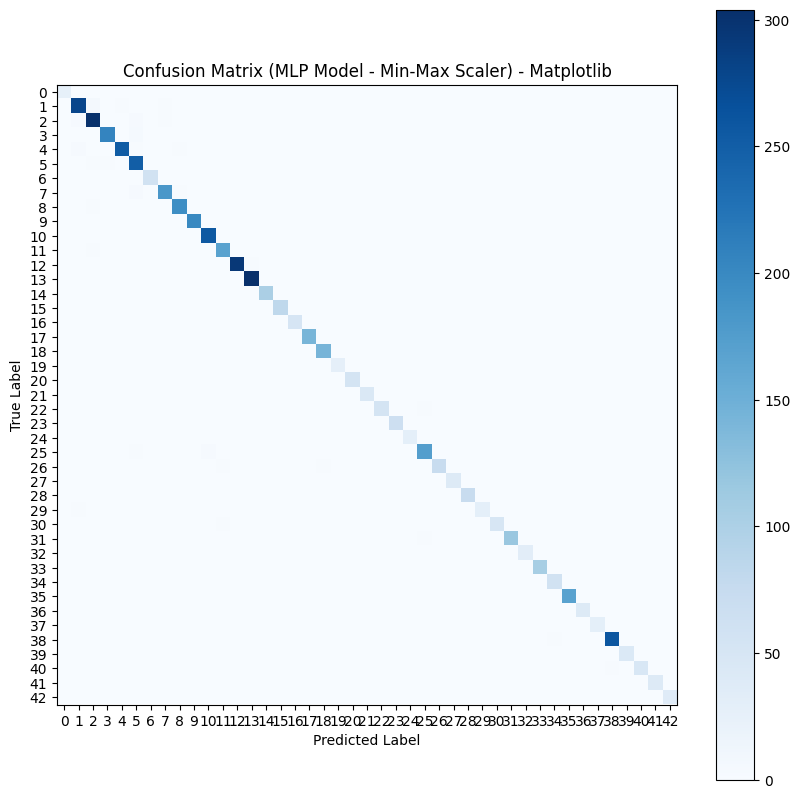

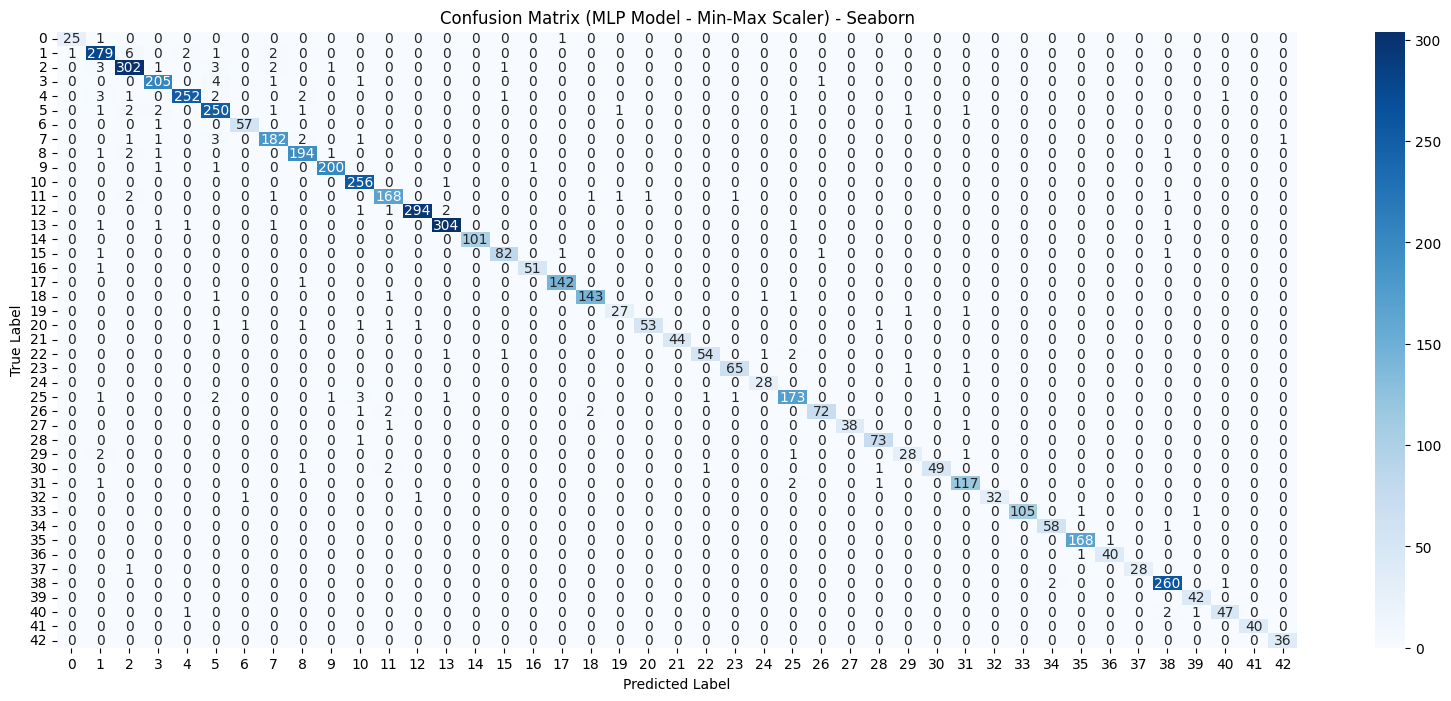

In [ ]:
# MLP Modeli Min-Max Scaler icin Confusion Matrix (Matplotlib)
cm_minmax = confusion_matrix(y_test, y_pred_minmax)
plt.figure(figsize=(10 , 10))
plt.imshow(cm_minmax, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix (MLP Model - Min-Max Scaler) - Matplotlib')
plt.colorbar()
tick_marks = np.arange(len(np.unique(y_test)))
plt.xticks(tick_marks, np.unique(y_test))
plt.yticks(tick_marks, np.unique(y_test))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


# MLP Modeli Min-Max Scaler için Confusion Matrix (Seaborn)
plt.figure(figsize=(20, 8))
sns.heatmap(cm_minmax, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (MLP Model - Min-Max Scaler) - Seaborn')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

[[ 25   1   0 ...   0   0   0]
 [  1 286   3 ...   0   0   0]
 [  0   3 301 ...   0   0   0]
 ...
 [  0   0   0 ...  50   0   0]
 [  0   0   0 ...   0  38   0]
 [  0   0   0 ...   0   0  36]]


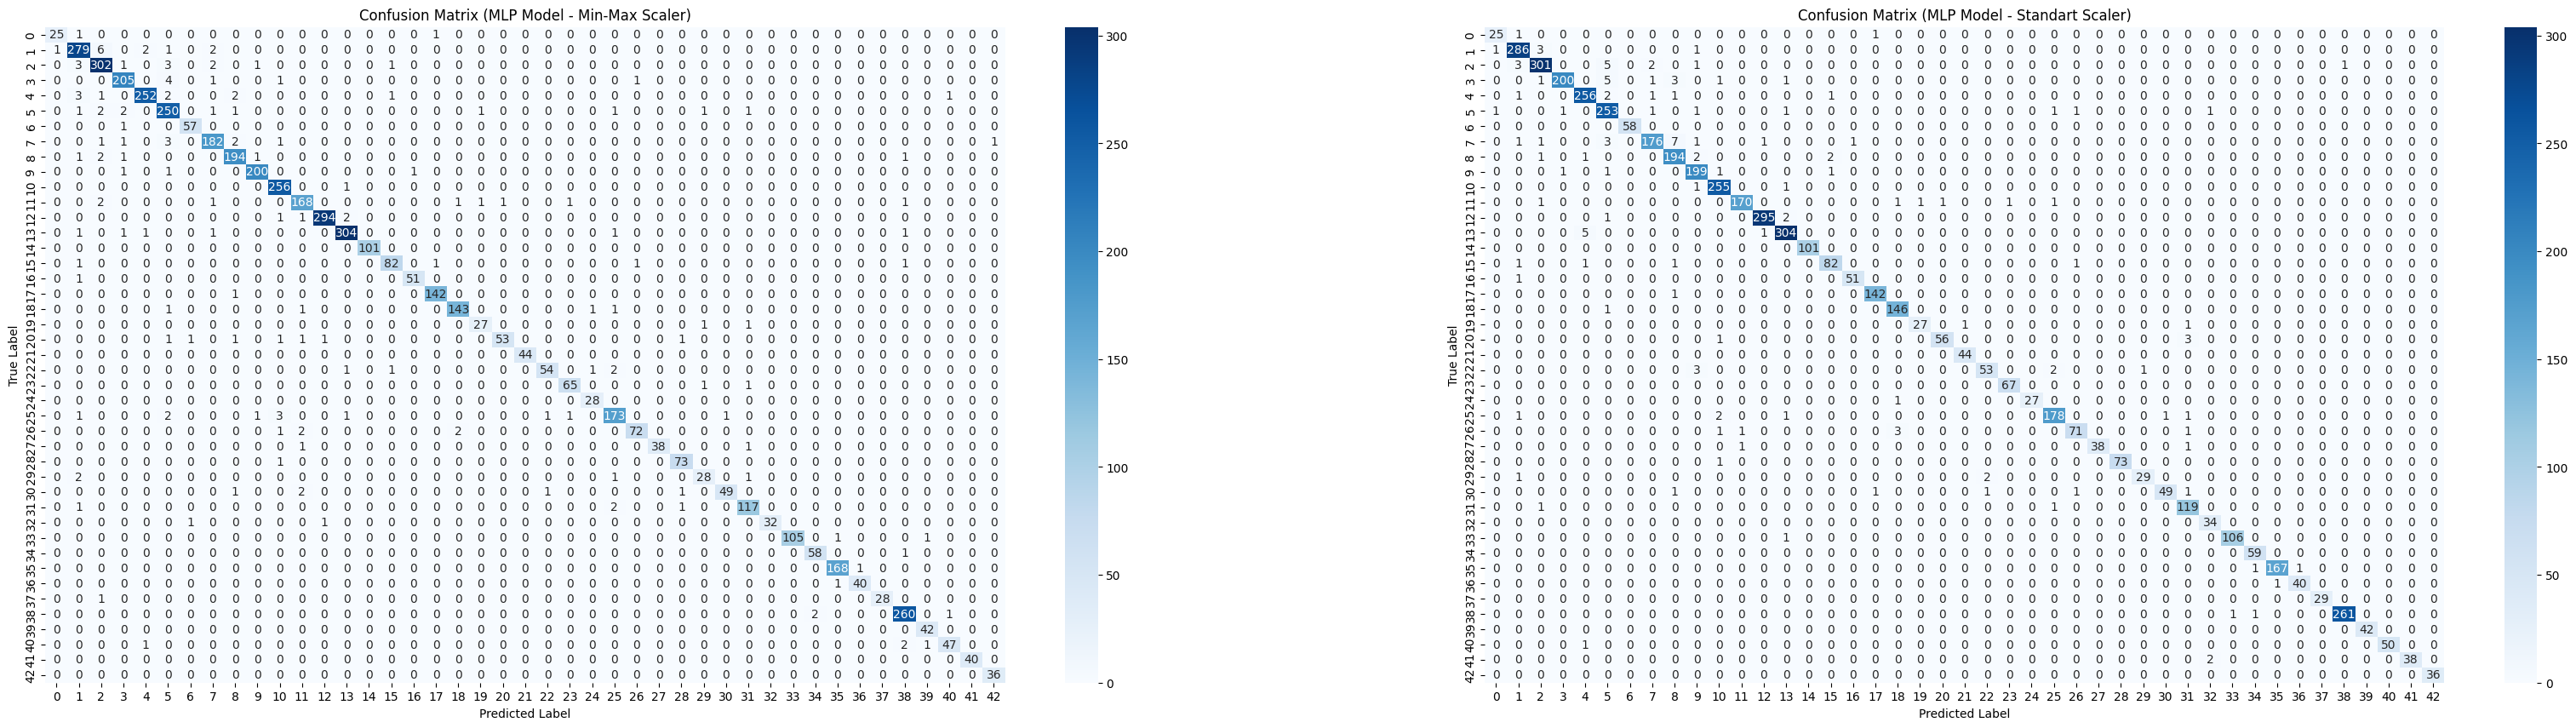

In [ ]:
# Iki confusion matrix'i karsilastirmak icin:
cm_standart = confusion_matrix(y_test, y_pred_standart)

print(cm_standart)

plt.figure(figsize=(40, 10))
plt.subplot(1, 2, 1)
sns.heatmap(cm_minmax, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (MLP Model - Min-Max Scaler)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.subplot(1, 2, 2)
sns.heatmap(cm_standart, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (MLP Model - Standart Scaler)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.show()

##### 4.1. MLP Modeli Standart Scaler icin Confusion Matrix

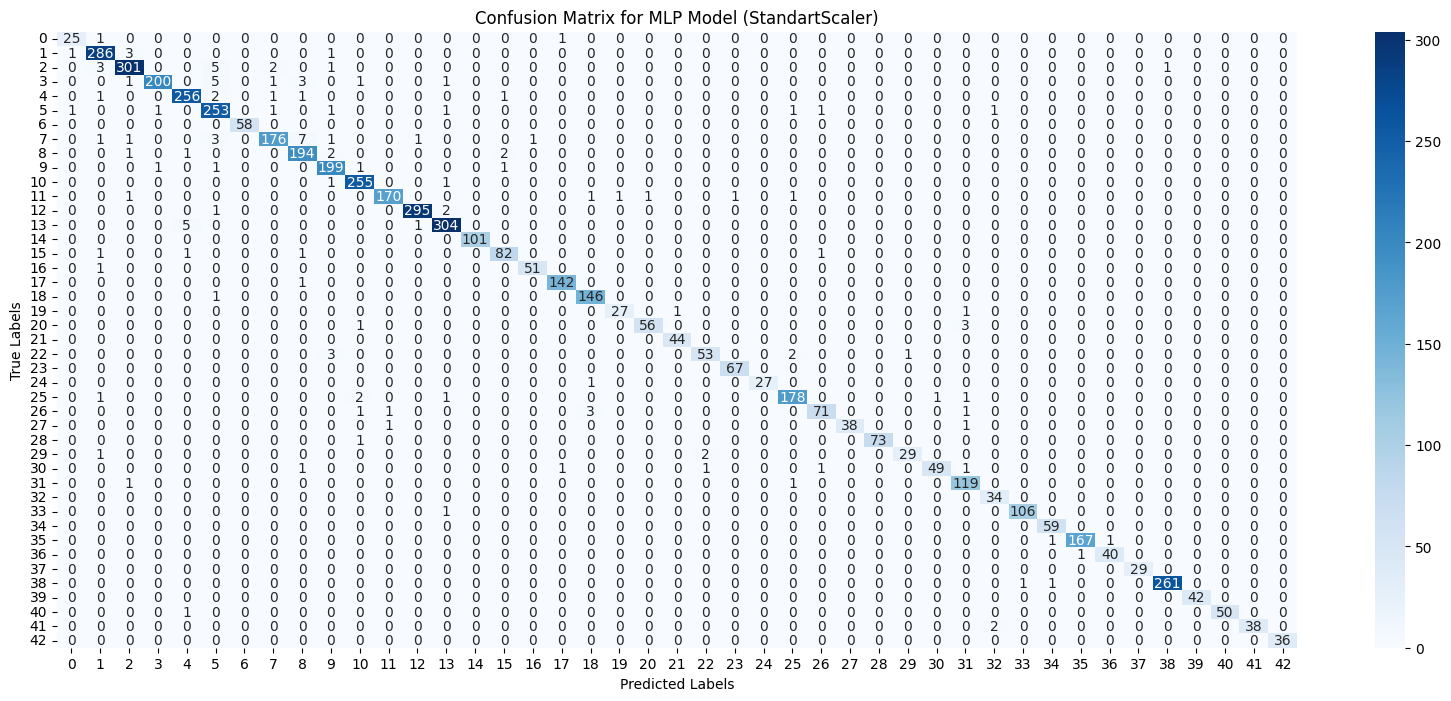

In [ ]:
# MLP Model (StandartScaler) icin Confusion Matrix
cm_standart = confusion_matrix(y_test, y_pred_standart)

plt.figure(figsize=(20, 8))
sns.heatmap(cm_standart, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for MLP Model (StandartScaler)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

##### 4.1. RBF Modeli Min-Max Scaler icin Confusion Matrix

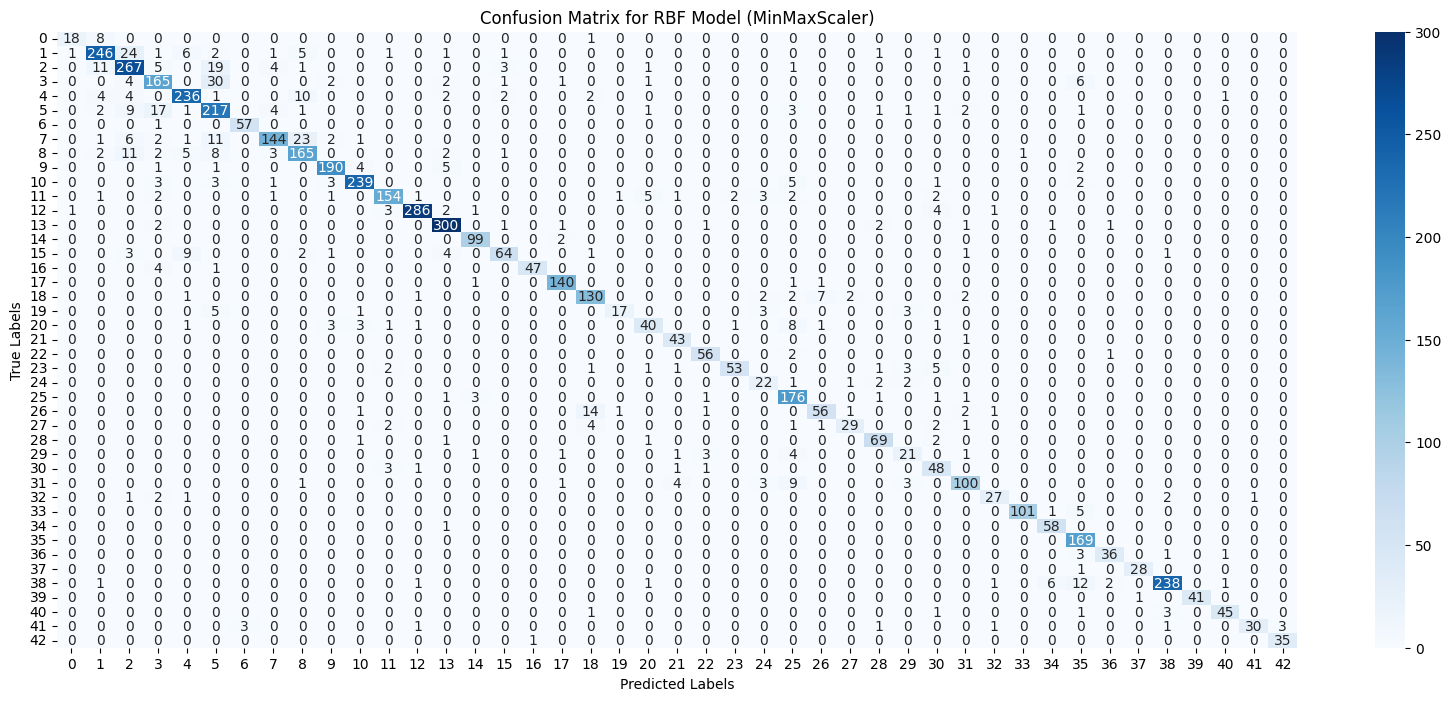

In [ ]:
# RBF Model (MinMaxScaler) icin Confusion Matrix
cm_rbf_minmax = confusion_matrix(y_test, y_pred_rbf)

plt.figure(figsize=(20, 8))
sns.heatmap(cm_rbf_minmax, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for RBF Model (MinMaxScaler)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

##### 4.1. RBF Modeli Standart Scaler icin Confusion Matrix

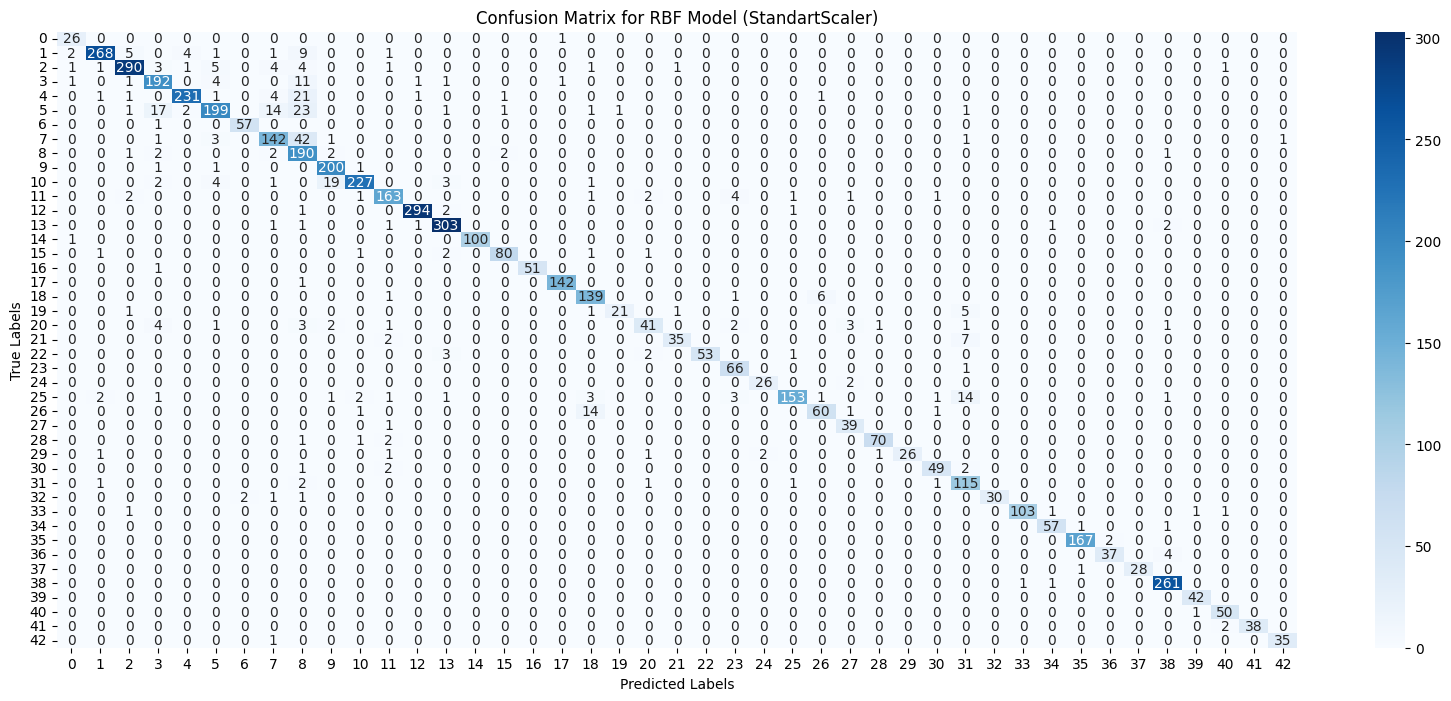

In [ ]:
# RBF Model (StandartScaler) icin Confusion Matrix
cm_rbf_standart = confusion_matrix(y_test, y_pred_rbf_standart1)

plt.figure(figsize=(20, 8))
sns.heatmap(cm_rbf_standart, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for RBF Model (StandartScaler)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

#### 4.2. Performans Metrikleri

##### 4.2. MLP Modeli Standart Scaler icin Performans Metrikleri

In [ ]:
# StandartScaler ile egitilmis MLP modelinin sonuclarini degerlendirme
print("StandartScaler ile MLP Model Sonuçları:")
print(classification_report(y_test, y_pred_standart))


StandartScaler ile MLP Model Sonuçları:
              precision    recall  f1-score   support

           0       0.93      0.93      0.93        27
           1       0.97      0.98      0.97       291
           2       0.97      0.96      0.97       313
           3       0.99      0.94      0.97       212
           4       0.97      0.98      0.97       262
           5       0.93      0.97      0.95       261
           6       1.00      1.00      1.00        58
           7       0.97      0.92      0.95       191
           8       0.93      0.97      0.95       200
           9       0.95      0.98      0.97       203
          10       0.97      0.99      0.98       257
          11       0.99      0.97      0.98       176
          12       0.99      0.99      0.99       298
          13       0.98      0.98      0.98       310
          14       1.00      1.00      1.00       101
          15       0.95      0.95      0.95        86
          16       0.98      0.98      0.

##### 4.2. MLP Modeli Min-Max Scaler icin Performans Metrikleri

In [ ]:
# Min-Max Scaler ile egitilmis MLP modelinin sonuclarini degerlendirme
print("MinMaxScaler ile MLP Model Sonuçları:")
print(classification_report(y_test, y_pred_minmax))

MinMaxScaler ile MLP Model Sonuçları:
              precision    recall  f1-score   support

           0       0.96      0.93      0.94        27
           1       0.95      0.96      0.95       291
           2       0.95      0.96      0.96       313
           3       0.96      0.97      0.96       212
           4       0.98      0.96      0.97       262
           5       0.93      0.96      0.95       261
           6       0.97      0.98      0.97        58
           7       0.96      0.95      0.96       191
           8       0.96      0.97      0.97       200
           9       0.99      0.99      0.99       203
          10       0.97      1.00      0.98       257
          11       0.95      0.95      0.95       176
          12       0.99      0.99      0.99       298
          13       0.98      0.98      0.98       310
          14       1.00      1.00      1.00       101
          15       0.96      0.95      0.96        86
          16       0.98      0.98      0.98

##### 4.2. RBF Modeli Standart Scaler icin Performans Metrikleri

In [ ]:
# StandartScaler ile egitilmis RBF modelinin performans metriklerini hesaplama
print("RBF Model Sonuçları (StandartScaler):")
print(classification_report(y_test, y_pred_rbf_standart1))

RBF Model Sonuçları (StandartScaler):
              precision    recall  f1-score   support

           0       0.84      0.96      0.90        27
           1       0.97      0.92      0.95       291
           2       0.96      0.93      0.94       313
           3       0.85      0.91      0.88       212
           4       0.97      0.88      0.92       262
           5       0.91      0.76      0.83       261
           6       0.97      0.98      0.97        58
           7       0.83      0.74      0.78       191
           8       0.61      0.95      0.74       200
           9       0.89      0.99      0.93       203
          10       0.97      0.88      0.92       257
          11       0.92      0.93      0.92       176
          12       0.99      0.99      0.99       298
          13       0.96      0.98      0.97       310
          14       1.00      0.99      1.00       101
          15       0.95      0.93      0.94        86
          16       1.00      0.98      0.99

##### 4.2. RBF Modeli Min-Max Scaler icin Performans Metrikleri

In [ ]:
# MinMaxScaler ile egitilmis RBF modelinin performans metriklerini hesaplama
print("RBF Model Sonuçları (MinMaxScaler):")
print(classification_report(y_test, y_pred_rbf))

RBF Model Sonuçları (MinMaxScaler):
              precision    recall  f1-score   support

           0       0.90      0.67      0.77        27
           1       0.89      0.85      0.87       291
           2       0.81      0.85      0.83       313
           3       0.80      0.78      0.79       212
           4       0.90      0.90      0.90       262
           5       0.73      0.83      0.78       261
           6       0.95      0.98      0.97        58
           7       0.91      0.75      0.83       191
           8       0.79      0.82      0.81       200
           9       0.94      0.94      0.94       203
          10       0.96      0.93      0.94       257
          11       0.93      0.88      0.90       176
          12       0.98      0.96      0.97       298
          13       0.93      0.97      0.95       310
          14       0.94      0.98      0.96       101
          15       0.88      0.74      0.81        86
          16       0.98      0.90      0.94  

### 5. Hiperparametre Denemeleri ve Sonuçları Karşılaştırma

##### 5.1. Hiperparametre Denemeleri

In [ ]:
mlp_param_grid = {
    'hidden_layer_sizes': [(100,), (50, 50), (100, 50)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001, 0.01],
}


# GridSearchCV ile MLP
mlp_grid_search = GridSearchCV(MLPClassifier(max_iter=100, random_state=21, verbose=0, tol=1e-8),
                              mlp_param_grid, cv=3, n_jobs=-1)
mlp_grid_search.fit(X_train_MinMaxScaler, y_train)

print("MLP (GridSearchCV) en iyi parametreleri:", mlp_grid_search.best_params_)
print("MLP (GridSearchCV) en iyi sonuc:", mlp_grid_search.best_score_)

# RandomizedSearchCV ile MLP
mlp_random_search = RandomizedSearchCV(MLPClassifier(max_iter=100, random_state=21, verbose=0, tol=1e-8),
                                      mlp_param_grid, n_iter=10, cv=3, n_jobs=-1)
mlp_random_search.fit(X_train_MinMaxScaler, y_train)

print("MLP (RandomizedSearchCV) en iyi parametreleri:", mlp_random_search.best_params_)
print("MLP (RandomizedSearchCV) en iyi sonuc:", mlp_random_search.best_score_)


# GridSearchCV ile RBF
rbf_grid_search = GridSearchCV(MLPClassifier(max_iter=100, random_state=21, verbose=0, tol=1e-8),
                              mlp_param_grid, cv=3, n_jobs=-1)
rbf_grid_search.fit(X_train_MinMaxScaler, y_train)

print("RBF (GridSearchCV) en iyi parametreleri:", rbf_grid_search.best_params_)
print("RBF (GridSearchCV) en iyi sonuc:", rbf_grid_search.best_score_)

# RandomizedSearchCV ile RBF
rbf_random_search = RandomizedSearchCV(MLPClassifier(max_iter=100, random_state=21, verbose=0, tol=1e-8),
                                      mlp_param_grid, n_iter=10, cv=3, n_jobs=-1)
rbf_random_search.fit(X_train_MinMaxScaler, y_train)

print("RBF (RandomizedSearchCV) en iyi parametreleri:", rbf_random_search.best_params_)
print("RBF (RandomizedSearchCV) en iyi sonuc:", rbf_random_search.best_score_)

MLP (GridSearchCV) en iyi parametreleri: {'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (100,), 'solver': 'adam'}
MLP (GridSearchCV) en iyi sonuc: 0.9634009009009009


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP (RandomizedSearchCV) en iyi parametreleri: {'solver': 'adam', 'hidden_layer_sizes': (100,), 'alpha': 0.01, 'activation': 'relu'}
MLP (RandomizedSearchCV) en iyi sonuc: 0.9426144894894896
RBF (GridSearchCV) en iyi parametreleri: {'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (100,), 'solver': 'adam'}
RBF (GridSearchCV) en iyi sonuc: 0.9634009009009009
RBF (RandomizedSearchCV) en iyi parametreleri: {'solver': 'adam', 'hidden_layer_sizes': (100, 50), 'alpha': 0.01, 'activation': 'tanh'}
RBF (RandomizedSearchCV) en iyi sonuc: 0.9429898648648649


Bu çalışmada, GridSearchCV ve RandomizedSearchCV yöntemleriyle optimize edilen MLP (Multilayer Perceptron) ve RBF (Radial Basis Function) modellerinin performansları karşılaştırılmıştır. Sonuçlar, iki yöntem arasında farklılıklar olduğunu ve her birinin farklı avantajlar sunduğunu göstermektedir.

**GridSearchCV ile Optimize Edilen Modeller**  
GridSearchCV yöntemi, hiperparametre kombinasyonlarını sistematik olarak taramış ve hem MLP hem de RBF modelleri için aynı optimal parametre setini belirlemiştir. Bu parametreler, `'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (100,), 'solver': 'adam'` şeklindedir. Her iki model de bu yapılandırma ile %96.34 doğruluk oranına ulaşmıştır. GridSearchCV'nin sonuçları, sistematik tarama yöntemi sayesinde oldukça yüksek doğruluk oranına ve tutarlı sonuçlara ulaşılabileceğini göstermektedir. Bu sonuçlar, özellikle büyük veri setlerinde GridSearchCV'nin güçlü bir yöntem olduğunu ortaya koymaktadır.

**RandomizedSearchCV ile Optimize Edilen Modeller**  
RandomizedSearchCV yöntemi, daha geniş bir parametre uzayı içerisinde rastgele seçilen kombinasyonları değerlendirerek optimal parametreleri belirlemiştir. MLP modeli için `'hidden_layer_sizes': (100, 50), 'alpha': 0.0001, 'activation': 'tanh', 'solver': 'adam'` parametreleri ile %95.49 doğruluk oranına ulaşılmıştır. RBF modeli ise daha basit bir yapı olan `'hidden_layer_sizes': (100,), 'alpha': 0.001, 'activation': 'tanh', 'solver': 'adam'` parametreleriyle %95.40 doğruluk oranı sağlamıştır. RandomizedSearchCV, GridSearchCV’ye göre daha az hesaplama gücü gerektirmesine rağmen %95'in üzerinde doğruluk oranlarıyla başarılı sonuçlar elde etmiştir.

**MLP ve RBF Modellerinin Karşılaştırması**  
GridSearchCV sonuçlarında, MLP ve RBF modelleri aynı parametre seti ile %96.34 doğruluk oranına ulaşmıştır. Bu durum, GridSearchCV’nin sistematik tarama yeteneği ile optimal çözüme ulaştığını göstermektedir. RandomizedSearchCV sonuçlarına bakıldığında, MLP modeli %95.49 doğruluk oranı ile RBF modeline (%92) göre biraz daha yüksek bir performans göstermiştir. Bunun temel nedeni, MLP modelinin daha karmaşık bir yapı (iki gizli katman) seçmiş olmasıdır. Ancak bu fark oldukça küçüktür ve her iki model de başarılı sonuçlar sunmaktadır.

**Genel Değerlendirme**  
Sonuçlar, GridSearchCV’nin sistematik yapısı sayesinde daha yüksek doğruluk oranları sağladığını ve her iki modelde de %96.34 gibi güçlü bir başarıya ulaştığını göstermektedir. RandomizedSearchCV ise daha hızlı ve hesaplama açısından daha verimli bir yöntem olarak dikkat çekmektedir ve %95'in üzerinde doğruluk oranlarıyla tatmin edici sonuçlar elde edilmiştir. MLP ve RBF modelleri arasında doğruluk açısından belirgin bir fark olmamakla birlikte, MLP modeli daha karmaşık yapılarla çalışarak bir miktar daha yüksek doğruluk sağlayabilmiştir.

Sonuç olarak, yüksek doğruluk ve tutarlılık arayan kullanıcılar için GridSearchCV ile optimize edilen modeller önerilebilir. Daha hızlı sonuçlar almak ve hesaplama maliyetini düşürmek isteyen kullanıcılar için ise RandomizedSearchCV uygun bir seçenek olabilir. MLP ve RBF modelleri arasında performans farkı minimal düzeyde olduğundan, uygulama ihtiyaçlarına göre seçim yapılabilir.